### 리뷰 기반 QA 시스템 구축하기

In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names('subjqa')
domains

C:\Users\knuyh\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
# 전자제품용
from datasets import load_dataset

subjqa = load_dataset('subjqa', name = 'electronics')

In [3]:
print(subjqa["train"]["answers"][1])
# 답은 text 필드
# answer_start 에 시작 문자의 인덱스 (Bass)

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [4]:
import pandas as pd

dfs = {split : dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items() :
    print(f"{split}에 있는 질문 개수 : {df['id'].nunique()}")

train에 있는 질문 개수 : 1295
test에 있는 질문 개수 : 358
validation에 있는 질문 개수 : 255


In [5]:
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


* 질문이 문법적으로 바르지 않다.
* 빈 answers.text 항목에는 리뷰에서 답을 찾지 못해 답변이 불가한 질문이 담김
* 시작 인덱스와 답변 길이를 사용해 리뷰에서 답변에 해당하는 텍스트 추출 가능

In [6]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

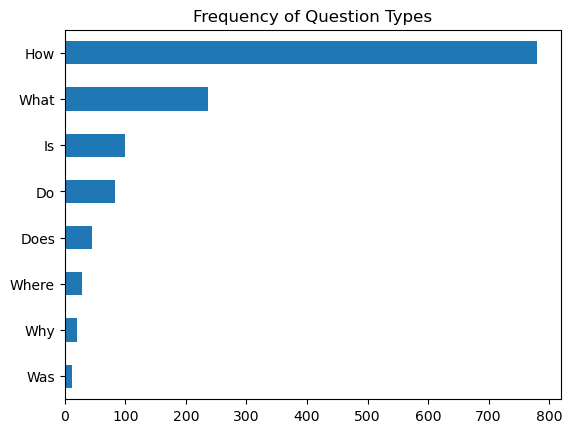

In [7]:
# 흔한 단어로 질문 개수 카운트
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [8]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


#### QA를 위한 텍스트 토큰화
* MiniLM 
: 99% 성능을 위지하며 두 배 빠른 BERT 기반의 압축 

<br>

    * 추출적 QA(문서에 있는 텍스트 일부를 질문의 답으로 추출) 작업에서는 입력을 (질문, 문맥) 쌍으로 제공

In [9]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [11]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df
# token_type_ids : 0은 질문 토큰, 1은 답변 토큰

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [12]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [13]:
# 모델 객체 초기화 및 입력 정방향 패스에 통과
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [14]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [15]:
print(f"입력 ID 크기: {inputs.input_ids.size()}")
print(f"시작 로짓 크기: {start_logits.size()}")
print(f"종료 로짓 크기: {end_logits.size()}")

입력 ID 크기: torch.Size([1, 28])
시작 로짓 크기: torch.Size([1, 28])
종료 로짓 크기: torch.Size([1, 28])


In [16]:
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"질문: {question}")
print(f"답변: {answer}")

질문: How much music can this hold?
답변: 6000 hours


In [17]:
# 토크나이저와 미세 튜닝된 모델 전달해 파이프라인 초기화
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

C:\Users\knuyh\anaconda3\Lib\site-packages\transformers\pipelines\question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516205072402954,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22082941234111786,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253491997718811,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

answers.answer_start가 비어있는 SubjQA 샘플처럼 답변이 불가한 질문도 있는데, 모델은 이 경우 [CLS] 토큰에 높은 시작 점수와 종료 점수 할당하고, 출력을 빈 문자열로 매핑한다.

In [18]:
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

#### 긴 텍스트 다루기

In [19]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

# return_overflowing_tokens : 슬라이딩 윈도 생성 
# ; [CLS] 토큰 임베딩에 충분한 정보 담겼다고 생각해 긴 텍스트 자르면, QA 작업에서는 문제

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [20]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} 윈도에는 {len(window)}개의 토큰이 있습니다.")

#0 윈도에는 100개의 토큰이 있습니다.
#1 윈도에는 88개의 토큰이 있습니다.


In [21]:
# 두 윈도가 어디서 겹치는지
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



#### 헤이스택을 사용해 QA 파이프라인 구축하기
실제 사용자는 제품에 대한 질문만 제공하여 말뭉치에 있는 전체 리뷰 중 관련된 텍스트를 선택할 방법이 필요하다.  
=> 해당 제품의 리뷰를 모두 연결해 하나의 긴 문맥으로 만들어 모델에 주입  
-> 하지만, 문맥이 극도로 길어져 사용자 쿼리에 대한 레이턴시를 수용하지 못함  
=> **리트리버-리더** 구조 기반으로 문제 처리

<br>

* 리트리버
    * 쿼리에서 관련된 문서 추출
    * 희소 or 밀집으로 구분
        * 희소 리트리버 : 단어 빈도를 사용해 각 문서와 쿼리를 희소 벡터로 표현, 내적을 계산해 쿼리와 문서의 관련성 결정
        * 밀집 리트리버 : 트랜스포머 같은 인코더 사용해 쿼리와 문서를 문맥화된 임베딩으로 표현, 쿼리 내용을 이해해 검색 정확도 향상
* 리더
    * 리트리버가 제공한 문서에서 답 추출
    * 독해 모델이지만, 자유 형식의 답변을 생성하는 모델도 있음 (본 절)

* 문서 저장소 초기화하기
    * 쿼리 시점에 리트리버로 제공하는 문서와 메타데이터를 저장하는 문서 전용 DB
    * 희소 리트리버 : TF-IDF
    * 밀집 리트리버 : Embedding, DPR
    * 양쪽 리트리버에 모두 호환되는 문서 저장소 : ElasticsearchDocumentStore

In [ ]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# 밀집 리트리버에서 사용할 문서 임베딩 반환
document_store = ElasticsearchDocumentStore(return_embedding = True)

meta에 있는 필드를 사용해 검색 과정에서 필터 적용

In [ ]:
# 노트북을 다시 시작할 때 일래스틱서치 저장소를 모두 비우는 것이 좋음
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

In [ ]:
# 모든 리뷰 인덱스에 저장
for split, df in dfs.items():
    # 중복 리뷰 제외
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")
    
print(f"{document_store.get_document_count()}개 문서가 저장되었습니다")

* 리트리버 초기화하기
    * 인덱스를 검색하기 위해 리트리버 필요

In [23]:
# 희소 리트리버 : TF-IDF
from haystack.nodes.retriever import BM25Retriever # ElasticsearchRetriever

bm25_retriever = BM25Retriever(document_store=document_store)

In [ ]:
# 이 제품이 독서에 유용한지
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm25_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})
# 각 원소는 문서를 나타내는 데 사용하는 헤이스택의 document 객체이고, 리트리버의 쿼리 점수와 그 외 메타데이터 포함

In [ ]:
print(retrieved_docs[0])

* 리더 초기화하기
    * 문서에서 답 추출
    * FASMReader
        * 트랜스포머 미세튜닝하고 배포되는 딥셋의 FARM 프레임워크 기반
    * TransformersReader
        * 트랜스포머 QA 파이프라인 기반, 추론만 실행
        * 각 구절의 시작 로짓과 종료 로짓을 softmax로 정규화
        * 같은 답을 다른 점수로 두 번 예측 -> FARM에서는 이런 중복 제거

In [ ]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

In [ ]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

* 모두 합치기

In [ ]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

In [ ]:
n_answers = 3
preds = pipe.run(query=query, 
                 params={"Retriever": {"top_k": 3, "filters": {"item_id": [item_id], "split": ["train"]}}, 
                                      "Reader": {"top_k": n_answers}})

print(f"질문: {preds['query']} \n")
for idx in range(n_answers):
    print(f"답변 {idx+1}: {preds['answers'][idx].answer}")
    print(f"해당 리뷰 텍스트: ...{preds['answers'][idx].context}...")
    print("\n\n")

### QA 파이프라인 개선하기
* 리트리버가 관련된 문서를 찾지 못한다면, 리더의 성능이 얼마나 좋은지는 중요하지 않음
* 특히 리트리버는 전체 QA 시스템 성능의 상한선을 설정하므로 리트리버의 성능을 높이는 것이 중요
#### 리트리버 평가하기
* 재현율 -> mAP ; 문서 순위에서 정답율 높은 위치에 놓은 리트리버에 보상 제공
* eval() : 오픈 도메인과 클로즈드 도메인 QA에 모두 사용 가능, 하지만 각 문서가 하나의 제품과 쌍을 이루어 모든 쿼리에서 제품 ID 필터링해야 하는 SubjQA 같은 데이터셋에서는 사용 X
* EvalDocuments 클래스와 리트리버 결합하는 사용자 정의 pipeline 생성

In [ ]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [ ]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # 리트리버에서 필터링을 위해 사용하는 메타데이터
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # 답이 있는 질문을 레이블에 추가
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # 답이 없는 질문을 레이블에 추가
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})
        labels.append(label)

In [ ]:
print(labels[0])
# origin : 질문 답변 쌍과 쿼리마다 문서 저장소 필터링할 수 있는 고유한 질문 ID 담김

In [ ]:
document_store.write_labels(labels, index="label")
print(f"""{document_store.get_label_count(index="label")}개의 \
질문 답변 쌍을 로드했습니다.""")

In [ ]:
# 파이프라인에 전달하기 위해 질문 ID와 상응하는 답변 매핑
# 고유 ID를 가진 모든 질문-답변 쌍 가져옴
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

In [ ]:
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

In [ ]:
print(f"재현율@3: {metrics['Retriever']['recall_single_hit']:.2f}")

In [ ]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "document_id", "gold_document_ids", "gold_id_match"]]

In [ ]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # 최대 top_k 계산
    max_top_k = max(topk_values)
    # 파이프라인 생성
    p = DocumentSearchPipeline(retriever=retriever)
    # 테스트 세트에 있는 질문-답변 쌍을 순회하며 최대 top_k로 추론 실행
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # 각 top_k 값에 대해 재현율 계산
    for topk in topk_values:
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")


bm25_topk_df = evaluate_retriever(bm25_retriever)

In [ ]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([bm25_topk_df], ["BM25"])

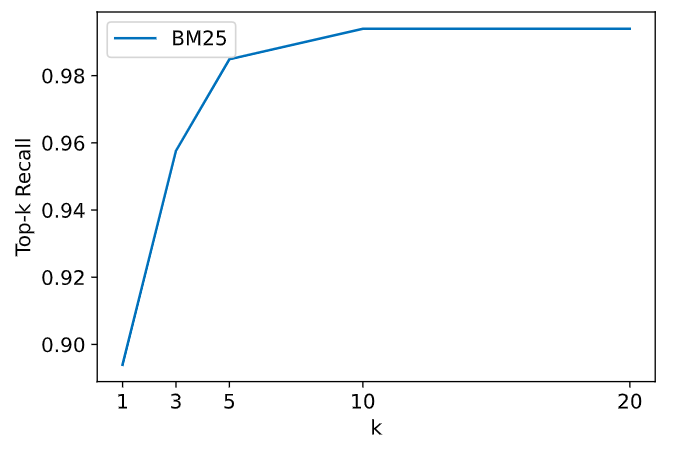

k=5에서 변곡점 있고, k=10부터 거의 완벽한 재현율 달성

* DPR
    * 밀집 리트리버
    * 희소 리트리버 : 사용자 쿼리의 단어가 리뷰에 들어있지 않으면 연관된 문서 검색하지 못하는 단점 -> DPR로 해결
    * 두 개의 BERT 모델 사용해 질문과 구절을 인코딩하는 개념

In [ ]:
from haystack.retriever.dense import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False) # 제품으로 필터링하므로 문서 제목을 연결해 추가 정보 얻지 못하게 False

In [ ]:
document_store.update_embeddings(retriever=dpr_retriever)

In [ ]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

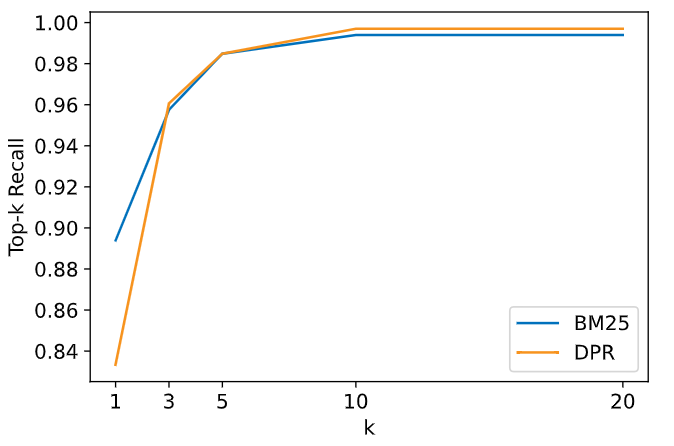

DPR은 재현율이 BM25보다 높지 않으며 k=3 에서 같아짐

#### 리더 평가하기
* EM -> 엄격
    * 예측 = 정답에 있는 문자 : EM=1
    * otherwise EM=0
    * 이진
* F1-score -> 유함
    * 정밀도와 재현율의 조화 평균

In [ ]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

In [ ]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

F1 score에만 의존하면 결과 왜곡될 가능성  
따라서 두 지표 모두 참고해 모델 성능의 과소평가(EM)와 과대평가(F1 score) 사이 균형 잡아야

In [ ]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

In [ ]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

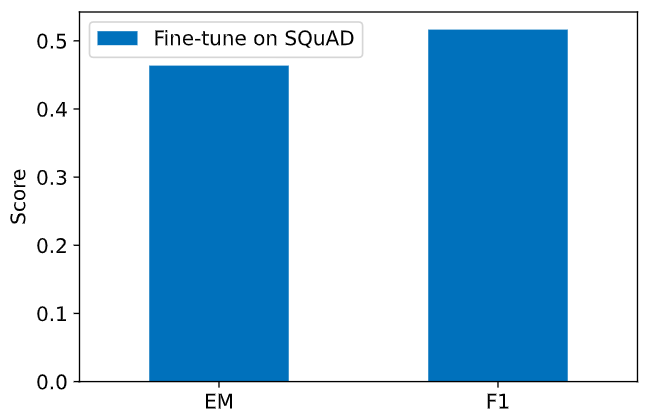

MiniLM이 SQuAD(EM 점수 76.1, F1 score 79.5) 보다 SubjQA에서 모델 성능이 떨어진다.  
   * 고객 리뷰가 SQuAD 데이터셋을 만드는 데 사용한 위키피디아 항목 본문과 크게 다르고 리뷰가 자유로운 형식이기에
   * 위키피디아에 있는 사실 정보와 달리, 데이터셋 질문과 답에는 주관성 내재
   
#### 도메인 적응
* SQuAD 에서 미세 튜닝한 모델은 다른 도메인에 잘 일반화되지만, SubjQA에서 모델의 EM과 F1 score는 SQuAD보다 훨씬 나쁘다. -> 과대적합
* 리더의 성능을 향상하는 방법은 MiniLM 모델을 SubjQA 훈련셋에서 미세 튜닝

In [ ]:
# 각 제품 ID에 연관된 paragraphs 배열 생성
# 이 배열의 원소는 하나의 문맥(리뷰)과 질문-답 쌍의 배열인 qas 담음
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # 특정 문맥으로 전체 질문-답 쌍 필터링
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # qas 배열 생성
        for qid, question in id2question.items():
            # 하나의 질문 ID에 대해 필터링
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # 답변 가능한 질문 추가
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # 질문-답 쌍을 qas에 추가
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # 문맥과 질문-답 쌍을 paragraphs에 추가
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [ ]:
# SQuAD 포맷 생성
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

In [ ]:
# 모든 제품 ID에 적용하고, json파일로 저장
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # 각 제품 ID에 대해 `paragraphs` 생성
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # 결과를 디스크에 저장
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

In [ ]:
# 리더 미세튜닝
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

In [ ]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

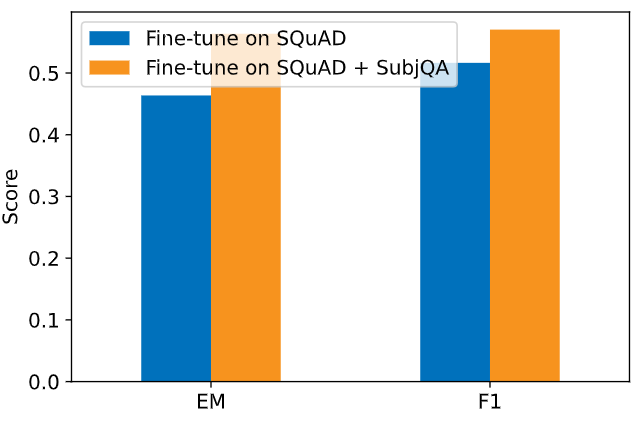

도메인 적응을 수행하니 두 점수 모두 향상  
사전 훈련된 언어 모델을 바로 SubjQA 훈련셋에 미세 튜닝하지 않는 이유 :   
SubjQA 훈련 샘플이 적고(1295), SQuAD에는 샘플이 많다.(100000개 이상) -> 과대적합 위험 발생

In [ ]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

In [ ]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

In [ ]:
# 테스트셋에서 평가
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

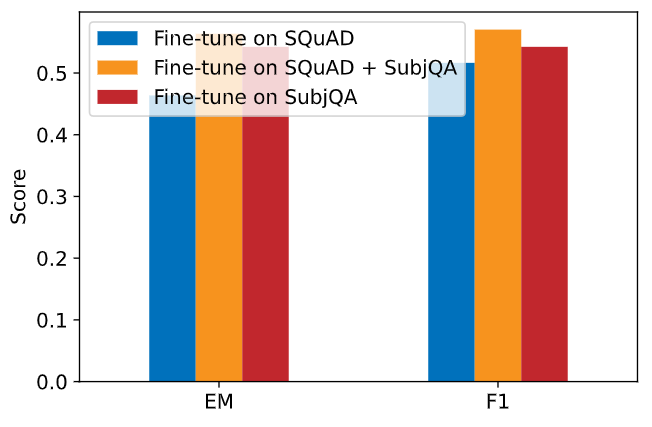

SubjQA에서 바로 미세 튜닝한 언어모델 < SQuAD와 SubjQA에서 미세 튜닝한 모델


#### 전체 QA 파이프라인 평가하기

In [ ]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# 평가하기
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# 리더에서 지표 추출
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

In [ ]:
# 리더와 전체 QA 파이프라인의 EM과 F1-점수 비교
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

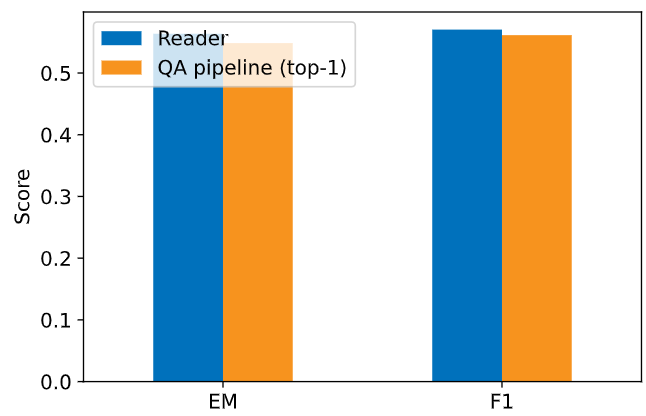

리트리버가 반환한 문서에서 정답을 예측하는 모델의 탑-1 EM과 탑-1 F1 score 점수 비교  
SQuAD 스타일의 평가에서와 같이 질문-문맥 쌍을 매칭하는 것에 비해 전체적으로 감소  
리더가 예측하는 답변의 개수 증가시켜 피할 수 있음


### 추출적 QA를 넘어서
* 문서에서 텍스트 범위로 답을 추출하는 것의 대안은 사전 훈련된 언어 모델로 답을 생성하는 **생성적 QA**
* RAG
    * 고전적인 리트리버-리더 구조 확장
    * 리더를 generator로 바꾸고 리트리버로 DPR 사용
    * generator는 T5나 BART 같은 사전 훈련된 시퀀스 - 투 - 시퀀스 트랜스포머
    * DPR로부터 문서의 잠재 벡터를 받고 쿼리와 문서를 기반으로 답변 반복적으로 생성
    * DPR과 generator가 미분 가능해 전체 과정을 엔드-투-엔드로 미세 튜닝 가능
    
    <br>
    
    * RAG-시퀀스 ; 하나의 추출 문서 사용해 완전한 답 생성
        * 특히 리트리버가 반환한 탑-k개 문서를 generator에 주입해 각 문서에서 출력 시퀀스 만들고 결과 합쳐 최선의 답 얻음
    * RAG-토큰 ; 여러 문서를 사용해 답에 있는 각 토큰 생성, generator가 여러 문서에서 단서를 찾아 합성
    * RAG-토큰 모델이 더 성능이 좋다.

In [ ]:
from haystack.generator.transformers import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

In [ ]:
# 리트리버와 generator 연결
from haystack.pipeline import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [ ]:
# 쿼리 주입해 RAG 실행
def generate_answers(query, top_k_generator=3): 
    preds = pipe.run(query=query, 
                     params={"Retriever": {"top_k":5, 
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})  
    print(f"질문: {preds['query']} \n")
    for idx in range(top_k_generator):
        # print(f"답변 {idx+1}: {preds['answers'][idx]['answer']}")
        print(f"답변 {idx+1}: {preds['answers'][idx].answer}")

In [ ]:
generate_answers(query)

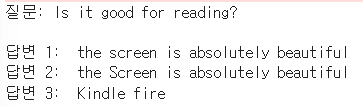

주관적인 특징이 generator 혼동 시킴

In [ ]:
generate_answers("What is the main drawback?")

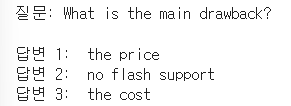

사실적인 질문에서 훨씬 좋다.  

<br>

SubjQA에서 엔드-투-엔드로 RAG 미세 튜닝하면 더 좋은 결과 얻는다.